<a href="https://colab.research.google.com/github/HammadN98/pytorch/blob/main/clusterizacao_Estudo_de_caso.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Projeto de aprendizado do uso de tecnicas de agrupamento clusterizacao

## **Objetivo**: Agrupar clientes com base em seus comportamentos de compra para identificar perfils diferentes.



## Pergunta a ser respondida: **Como podemos dividir nossos clientes em grupos que tenham comportamento de compra semelhante?**

### 0.1 Reconhecimento dos dados

In [1]:
import pandas as pd

# Carregar o dataset
URL = "https://github.com/HammadN98/Estudos-de-caso/raw/refs/heads/main/Dados/Online_Retail.xlsx"
data = pd.read_excel(URL)

#data = pd.read_excel("/content/Online_Retail.xlsx")

# Visualizar as primeiras linhas do dataset
print(data.head())

  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  


In [2]:
# Verificar informações do dataset
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB
None


In [3]:
# Descrever as estatísticas gerais
print(data.describe())

            Quantity                    InvoiceDate      UnitPrice  \
count  541909.000000                         541909  541909.000000   
mean        9.552250  2011-07-04 13:34:57.156386048       4.611114   
min    -80995.000000            2010-12-01 08:26:00  -11062.060000   
25%         1.000000            2011-03-28 11:34:00       1.250000   
50%         3.000000            2011-07-19 17:17:00       2.080000   
75%        10.000000            2011-10-19 11:27:00       4.130000   
max     80995.000000            2011-12-09 12:50:00   38970.000000   
std       218.081158                            NaN      96.759853   

          CustomerID  
count  406829.000000  
mean    15287.690570  
min     12346.000000  
25%     13953.000000  
50%     15152.000000  
75%     16791.000000  
max     18287.000000  
std      1713.600303  


## 1. Pre-processamento dos dados

1. Verificar valores ausentes e lidar com eles se necessario
2. Verificar outliers e lidar com eles
2. Como algoritimos e clusterizacao(eg. K-Means e cluster hierarquico, e imagino que a maioria seja) sao sensiveis a escala, sera necessario deixar todas as variaveis a serem utilizadas na mesma escala.

In [4]:
# 1. Remover a coluna CustumerID
data.drop(columns=['CustomerID'], inplace=True)

1.1 Tratando dos valores negativos

Pergunta: O que sao esses valores mnegativos? Erros de entrada?

In [5]:

# Quantidade de negativos 'Quantity'
cont_negativos_quantidade = data[data['Quantity'] < 0].shape[0]

# Quantidade de negativos  'UnitPrice'
cont_negativos_preco = data[data['UnitPrice'] < 0].shape[0]

print(f"Quantidade de valores negativos em Quantity: {cont_negativos_quantidade}")
print(f"Quantidade de valores negativos em UnitPrice: {cont_negativos_preco}")

Quantidade de valores negativos em Quantity: 10624
Quantidade de valores negativos em UnitPrice: 2


In [6]:
#QUais ssao o valores negativos nas colunas?
negativo_uniprice = data[data['UnitPrice'] < 0]
negativo_uniprice

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
299983,A563186,B,Adjust bad debt,1,2011-08-12 14:51:00,-11062.06,United Kingdom
299984,A563187,B,Adjust bad debt,1,2011-08-12 14:52:00,-11062.06,United Kingdom


In [7]:
# vendo os regsitros entre 299980 e 299990
entre_80_90 = data.loc[299980:299990]
print(entre_80_90)

       InvoiceNo StockCode                        Description  Quantity  \
299980    563184    82494L        WOODEN FRAME ANTIQUE WHITE          4   
299981    563184     82482  WOODEN PICTURE FRAME WHITE FINISH         4   
299982   A563185         B                    Adjust bad debt         1   
299983   A563186         B                    Adjust bad debt         1   
299984   A563187         B                    Adjust bad debt         1   
299985    563188     79160      HEART SHAPE WIRELESS DOORBELL        48   
299986    563188     22728          ALARM CLOCK BAKELIKE PINK        12   
299987    563188     23108         SET OF 10 LED DOLLY LIGHTS         4   
299988    563188     23321        SMALL WHITE HEART OF WICKER        12   
299989    563188     23322        LARGE WHITE HEART OF WICKER         6   
299990    563188     21731      RED TOADSTOOL LED NIGHT LIGHT        12   

               InvoiceDate  UnitPrice         Country  
299980 2011-08-12 14:50:00       2.95  Unit

Esta valor negativo foi uma manobra para  contornar um registro anterior errado. Foi acrescido um valor de '11062.06' de maneira incorreta, e para contornar foi registrado um valor '-11062.06' e alem foi feito de maneira duplicada. Ou seja como ja se trata de um erro desde o inicio, e mais facil excluir os tres registros outliers e seguir descobrindo se tem mais.

In [8]:
data.drop([299982, 299983, 299984], inplace=True)

In [9]:
#Para seguir investigando a coluna
print(data['UnitPrice'].describe())

count    541906.000000
mean          4.631552
std          93.192775
min           0.000000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64


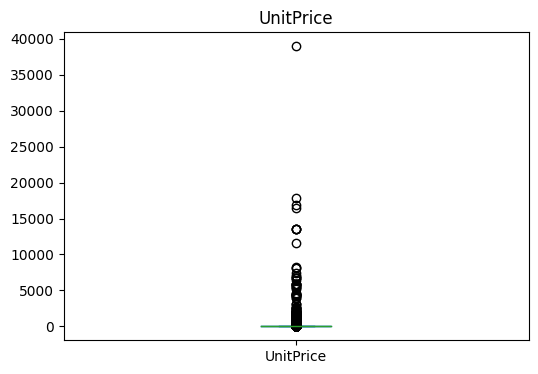

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))

data['UnitPrice'].plot(kind='box')

plt.title('UnitPrice')
plt.show();

COm esse grafico aliado ao faot de ate 75% dos dados tem um valor ate 4.13 e possivel que aja muitos outliers ainda. A pesquisar

In [11]:
# Quantidade de cada valor em 'UnitPrice'
cont_unitprice = data['UnitPrice'].value_counts()
print(cont_unitprice)

UnitPrice
1.25      50496
1.65      38181
0.85      28497
2.95      27768
0.42      24533
          ...  
84.21         1
46.86         1
28.66         1
156.45        1
224.69        1
Name: count, Length: 1628, dtype: int64


In [12]:
#data[data['UnitPrice'] > 100].shape[0]
#data[data['UnitPrice'] > 100].value_counts()
data[data['UnitPrice'] > 300]['UnitPrice'].value_counts()


,count
UnitPrice,
451.42,4
557.72,4
550.64,4
1241.98,4
1687.17,4
...,...
523.00,1
5876.40,1
7006.83,1


In [13]:
data_100 = data[data['UnitPrice'] > 1500].groupby(['UnitPrice', 'Description']).size().reset_index(name='Count')
data_100.head(50)

,UnitPrice,Description,Count
0,1500.36,DOTCOM POSTAGE,1
1,1526.76,DOTCOM POSTAGE,1
2,1556.08,DOTCOM POSTAGE,1
3,1563.00,DOTCOM POSTAGE,1
4,1569.04,DOTCOM POSTAGE,1
5,1592.49,Manual,2
6,1599.26,DOTCOM POSTAGE,1
7,1683.75,DOTCOM POSTAGE,1
8,1687.17,Manual,4
9,1714.17,DOTCOM POSTAGE,1


In [14]:
#data['Description'].value_counts().tail(50)
#data['Description'].unique()
for description in data['Description'].unique():
    print(description)

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

Nota-se que os errados estao em minusculo enquanto os valores certos tem a descricao em maiusculo, visualizando por cima achei apenas um valor que esta em maiusculo e esta errado. Logo irei eliminar do data set todos os valores que descricao estiver com minuscula.


In [15]:
data_clean = data.dropna(subset=['Description'])
data_clean = data_clean[data_clean['Description'].notna()]

data_clean['Description'] = data_clean['Description'].astype(str)

data_capslock = data_clean[data_clean['Description'].str.isupper()]

print(data_capslock)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice         Country  
0      2010-12-01 0

In [16]:
for description in data_capslock['Description'].unique():
    print(description)
data_capslock

WHITE HANGING HEART T-LIGHT HOLDER
WHITE METAL LANTERN
CREAM CUPID HEARTS COAT HANGER
KNITTED UNION FLAG HOT WATER BOTTLE
RED WOOLLY HOTTIE WHITE HEART.
SET 7 BABUSHKA NESTING BOXES
GLASS STAR FROSTED T-LIGHT HOLDER
HAND WARMER UNION JACK
HAND WARMER RED POLKA DOT
ASSORTED COLOUR BIRD ORNAMENT
POPPY'S PLAYHOUSE BEDROOM 
POPPY'S PLAYHOUSE KITCHEN
FELTCRAFT PRINCESS CHARLOTTE DOLL
IVORY KNITTED MUG COSY 
BOX OF 6 ASSORTED COLOUR TEASPOONS
BOX OF VINTAGE JIGSAW BLOCKS 
BOX OF VINTAGE ALPHABET BLOCKS
HOME BUILDING BLOCK WORD
LOVE BUILDING BLOCK WORD
RECIPE BOX WITH METAL HEART
DOORMAT NEW ENGLAND
JAM MAKING SET WITH JARS
RED COAT RACK PARIS FASHION
YELLOW COAT RACK PARIS FASHION
BLUE COAT RACK PARIS FASHION
BATH BUILDING BLOCK WORD
ALARM CLOCK BAKELIKE PINK
ALARM CLOCK BAKELIKE RED 
ALARM CLOCK BAKELIKE GREEN
PANDA AND BUNNIES STICKER SHEET
STARS GIFT TAPE 
INFLATABLE POLITICAL GLOBE 
VINTAGE HEADS AND TAILS CARD GAME 
SET/2 RED RETROSPOT TEA TOWELS 
ROUND SNACK BOXES SET OF4 WOODLAND 
SPA

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,France


In [17]:
#data_capslock[data_capslock['UnitPrice'] > 3000]['UnitPrice'].value_counts()

unit_description = data_capslock[data_capslock['UnitPrice'] > 2500].groupby(['UnitPrice', 'Description']).size().reset_index(name='Count')
unit_description.head(50)

,UnitPrice,Description,Count
0,4383.62,AMAZON FEE,1
1,4505.17,DOTCOM POSTAGE,1
2,4527.65,AMAZON FEE,1
3,4534.24,AMAZON FEE,1
4,4575.64,AMAZON FEE,1
5,5225.03,AMAZON FEE,1
6,5258.77,AMAZON FEE,1
7,5519.25,AMAZON FEE,1
8,5522.14,AMAZON FEE,1
9,5575.28,AMAZON FEE,1


PErcebe-se agora que vendas muito altas nao sao outliers, e sim vendas feitas pela Amazon/Internet. Deve ser possivel que as vendas sejam lancadas todas juntas. E por isso a descricao fica por uma so, como se fosse um registro de vendas.

### 1.1 Validando a coluna Country

Caso todas as compras sejam feitas no mesmo pais, ela sera excluida.

In [18]:
pais = data_capslock['Country'].value_counts()
print(pais)

Country
United Kingdom          491130
Germany                   9468
France                    8527
EIRE                      8152
Spain                     2523
Netherlands               2369
Belgium                   2060
Switzerland               1999
Portugal                  1505
Australia                 1259
Norway                    1075
Italy                      799
Channel Islands            756
Finland                    694
Cyprus                     620
Sweden                     458
Unspecified                441
Austria                    400
Denmark                    388
Japan                      355
Poland                     340
Israel                     297
USA                        290
Hong Kong                  282
Singapore                  214
Iceland                    182
Canada                     150
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         57


Teoria invalidada, a grnade maioria esmagadore e UK, a coluna segue

### 1.2 Resolvendo as Quantidades negativas

E possivel que as quantidades negativas sejam uma maneira de arrumar um lancamento errado, logo para excluir os negativos eu preciso excluir os positivos quelancados errados e resultaram nos negativos....

In [19]:
data_capslock[data_capslock['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom
...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,United Kingdom
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,United Kingdom


In [20]:
data_100 = data_capslock.groupby(['InvoiceNo', 'Description']).size().reset_index(name='Count')
data_100.head(50)

,InvoiceNo,Description,Count
0,536365,CREAM CUPID HEARTS COAT HANGER,1
1,536365,GLASS STAR FROSTED T-LIGHT HOLDER,1
2,536365,KNITTED UNION FLAG HOT WATER BOTTLE,1
3,536365,RED WOOLLY HOTTIE WHITE HEART.,1
4,536365,SET 7 BABUSHKA NESTING BOXES,1
5,536365,WHITE HANGING HEART T-LIGHT HOLDER,1
6,536365,WHITE METAL LANTERN,1
7,536366,HAND WARMER RED POLKA DOT,1
8,536366,HAND WARMER UNION JACK,1
9,536367,ASSORTED COLOUR BIRD ORNAMENT,1


In [21]:
data_capslock[data_capslock['Quantity'] < 0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom
238,C536391,21980,PACK OF 12 RED RETROSPOT TISSUES,-24,2010-12-01 10:24:00,0.29,United Kingdom
...,...,...,...,...,...,...,...
540448,C581490,22178,VICTORIAN GLASS HANGING T-LIGHT,-12,2011-12-09 09:57:00,1.95,United Kingdom
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,United Kingdom


In [22]:
entre_80_90 = data.loc[220:260]
print(entre_80_90[['InvoiceNo', 'Description', 'Quantity']])

    InvoiceNo                          Description  Quantity
220    536390   WHITE HANGING HEART T-LIGHT HOLDER        64
221    536390                 SMALL POPCORN HOLDER       100
222    536390                LARGE POPCORN HOLDER         50
223    536390             RETROSPOT LARGE MILK JUG        12
224    536390  SET/20 RED RETROSPOT PAPER NAPKINS         96
225    536390        SET/6 RED SPOTTY PAPER PLATES        96
226    536390          SET/6 RED SPOTTY PAPER CUPS        48
227    536390                   POLKADOT RAIN HAT        144
228    536390                   DELUXE SEWING KIT         40
229    536390     RETROSPOT HEART HOT WATER BOTTLE        24
230    536390  KNITTED UNION FLAG HOT WATER BOTTLE        24
231    536390        ENGLISH ROSE HOT WATER BOTTLE        24
232    536390                           PHOTO CUBE        48
233    536390         HOMEMADE JAM SCENTED CANDLES        96
234    536390              JUMBO BAG RED RETROSPOT       100
235   C536391       PLAS

aparentemente os valores negativos nao tem seus correspondentes positivos, como se fossem vendas e devolucoes. ENtao todas as quantidades negativas serao excluidas.

In [23]:
#data_capslock[data_capslock['Quantity'] < 0]
data_capslock = data_capslock[data_capslock['Quantity'] >= 0]
data_capslock

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,United Kingdom
...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,France


### 1.3 Validando a coluna 'InvoiceNo'

Esta coluna deveria ser numerica, por a registros que envolvel strigs. Por que?

In [24]:
for nro in data_capslock['InvoiceNo'].unique():
    print(nro)

A saída de streaming foi truncada nas últimas 5000 linhas.
570428
570429
570430
570441
570442
570443
570444
570445
570446
570448
570449
570452
570455
570457
570458
570459
570461
570462
570465
570466
570467
570470
570472
570473
570474
570475
570479
570481
570482
570485
570488
570489
570491
570492
570493
570494
570495
570496
570497
570498
570499
570500
570501
570502
570503
570504
570505
570506
570507
570509
570510
570511
570512
570513
570514
570516
570517
570521
570522
570554
570555
570557
570590
570591
570592
570593
570594
570597
570598
570600
570601
570602
570632
570634
570637
570638
570640
570642
570646
570648
570649
570650
570651
570652
570653
570656
570657
570659
570660
570661
570662
570663
570664
570665
570666
570667
570668
570669
570670
570671
570672
570673
570674
570675
570676
570677
570678
570679
570680
570681
570682
570685
570688
570690
570693
570694
570695
570696
570697
570698
570699
570700
570701
570702
570703
570706
570707
570713
570714
570715
570716
570717
570718
570719
570

Ao remover os valores de quantidade negativo, os valores de InvoiceNo foram resolvidos, ja que foram excluidos os registros que contiam 'C' antes dos numeros.

## 2.Escalonamento dos dados

In [25]:
from sklearn.preprocessing import StandardScaler
try:
  scaler = StandardScaler()
  dados_normalizados = scaler.fit_transform(data_capslock)
  print(dados_normalizados[:5])
except:
  pass

PAra usar o StandarScaler() sera necessario estar apenas com colunas numericas. Logo as colunas que estao em formato de string e foram importantes sera codificadas em One-Hot Encoding e as demais excluidas.

In [26]:
data_capslock['Description'].nunique()
#Description segue

3998

In [27]:
data_capslock['StockCode'].nunique()


3891

In [28]:
data_capslock['Country'].nunique()


38

As colunas categoricas ['Description', 'StockCode', 'Country'] serao transformadas em valores numericos.

In [29]:
print(data_capslock.info())

<class 'pandas.core.frame.DataFrame'>
Index: 528455 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    528455 non-null  object        
 1   StockCode    528455 non-null  object        
 2   Description  528455 non-null  object        
 3   Quantity     528455 non-null  int64         
 4   InvoiceDate  528455 non-null  datetime64[ns]
 5   UnitPrice    528455 non-null  float64       
 6   Country      528455 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 32.3+ MB
None


In [30]:
data_capslock = data_capslock.drop(columns=['InvoiceDate'])

In [31]:
data_numerico = data_capslock.select_dtypes(include=['float64', 'int64'])
scaler = StandardScaler()
data_numerico_scaled = scaler.fit_transform(data_numerico)

In [32]:
from sklearn.preprocessing import LabelEncoder
# Certifique-se de que todas as colunas categóricas são do tipo string
data_categorico = data_capslock[['InvoiceNo','Description','StockCode', 'Country']]
data_categorico_encoded = data_categorico.copy()

for col in ['InvoiceNo', 'Description', 'StockCode', 'Country']:
    data_categorico_encoded[col] = data_categorico_encoded[col].astype(str)  # Converte para string

label_encoder = LabelEncoder()

# Aplicar Label Encoding
for col in data_categorico_encoded.columns:
    data_categorico_encoded[col] = label_encoder.fit_transform(data_categorico_encoded[col])


In [33]:
data_final = pd.DataFrame(data_numerico_scaled, columns=data_numerico.columns)
data_final = pd.concat([data_final, data_categorico_encoded.reset_index(drop=True)], axis=1)

In [34]:
data_final

,Quantity,UnitPrice,InvoiceNo,Description,StockCode,Country
0,-0.028987,-0.043085,0,3816,3385,36
1,-0.028987,-0.012925,0,3824,2708,36
2,-0.016213,-0.035904,0,881,2931,36
3,-0.028987,-0.012925,0,1841,2876,36
4,-0.028987,-0.012925,0,2821,2875,36
...,...,...,...,...,...,...
528450,0.009335,-0.104124,19846,2299,1477,13
528451,-0.028987,-0.059243,19846,711,1750,13
528452,-0.041761,0.014363,19846,717,2091,13
528453,-0.041761,0.014363,19846,716,2092,13


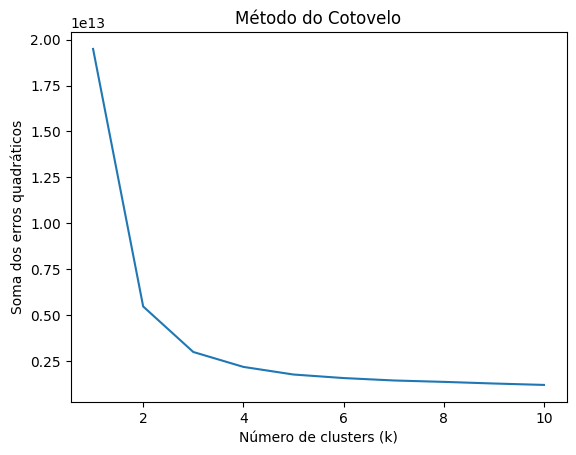

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Encontrar o número ideal de clusters
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_final)
    sse.append(kmeans.inertia_)

# Visualizar o gráfico do Método do Cotovelo
plt.plot(k_range, sse)
plt.xlabel('Número de clusters (k)')
plt.ylabel('Soma dos erros quadráticos')
plt.title('Método do Cotovelo')
plt.show()


k = 3

In [36]:
# Aplicar K-means com o valor ótimo de k
k_top =3
kmeans = KMeans(n_clusters=k_top, random_state=42)
clusters = kmeans.fit_predict(data_final)

# Adicionar os clusters aos dados originais
data_final['Cluster'] = clusters

# Verificar as médias de cada cluster
print(data_final.groupby('Cluster').mean())


         Quantity  UnitPrice     InvoiceNo  Description    StockCode  \
Cluster                                                                
0        0.003974  -0.005082  10172.428367  2087.388253  1576.110170   
1       -0.001732  -0.005816  16713.196394  2090.624767  1664.554705   
2       -0.001912   0.011255   3202.342492  2014.571591  1514.307463   

           Country  
Cluster             
0        33.964619  
1        34.364695  
2        34.478006  


## 3.Interpretandos resultados

1. Quantity
  * os clientes do cluster **0** compram uma quantidade de itens maiores que a media dos dados, ja os clusters **1, 2** compram menos que a media.

2. UnitPrice
  * Os clientes do cluster **2** compram produtos de valor unitario mais elavado, ja os clientes **0, 1** tendem a comprar produtos de valor unitario abaixo da madeia global dos dados.

3. Country
  * Como os valores para os tres clusters sao parecidos, indica que a variavel 'Country' nao contribui de maneira significativa para a diferenciacao dos dados.

4. Colunas ['InvoiceNo', 'Description', 'StockCode']
  * Nao representam uso pratico. Logo elas pode ser auteradas, usadas para a criacao de novas variaveis ou excluidas de vez.